In [ ]:
import os
path = "D:\yelp"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import precision_score, make_scorer, recall_score
import nltk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy import spatial
from sklearn.neighbors import KNeighborsClassifier
Stop_words = set(stopwords.words('english')) 
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
businesses_path = os.path.join(path, 'yelp_academic_dataset_business.json\yelp_academic_dataset_business.json')
reviews_path = os.path.join(path, 'yelp_academic_dataset_review.json\yelp_academic_dataset_review.json')
users_path = os.path.join(path, 'yelp_academic_dataset_user.json\yelp_academic_dataset_user.json')

businesses = pd.read_json(businesses_path, lines=True, orient='columns', chunksize=1000000)
reviews = pd.read_json(reviews_path, lines=True, orient='columns', chunksize=1000000)
users = pd.read_json(users_path,lines=True, orient='columns', chunksize=1000000)

for bus in businesses:
    business_df = bus
    break
for rev in reviews:
    review_df = rev                
    break
# for user in users:
#     user_df = user
#     break

In [ ]:
review_df = review_df[['review_id', 'user_id', 'business_id', 'stars', 'text']]

rest_bools = business_df.apply(lambda x: x['attributes'] != None and 'RestaurantsPriceRange2' in x['attributes'], axis = 1)
all_rest_ids = set(business_df[rest_bools]['business_id'])

review_df = review_df[review_df.apply(lambda x: x['business_id'] in all_rest_ids, axis = 1)]

In [ ]:
user_to_review = {} # userID : all reviews by user
business_to_user = {} # businessID : all reviewerIDs that left a review for that business
user_feature = {}

In [ ]:
def remove_stop_words(text):
    res = re.sub(r'[^\w\s]', ' ', text)
    word_tokens = word_tokenize(res)
    filtered_sentence = [w for w in word_tokens if not w.lower() in Stop_words]
    return " ".join(filtered_sentence)

In [ ]:
def setup(review_df):
    for index, row in review_df.iterrows():
        user = row['user_id']
        business = row['business_id']
        text = row['text']
        text = remove_stop_words(text).lower()
        if user not in user_to_review:
            user_to_review[user] = []
        user_to_review[user].append(text)
        if business not in business_to_user:
            business_to_user[business] = []
        rating = 0
        if row['stars'] > 2.5:
          rating = 1
        business_to_user[business].append((user,rating))

def k_nearest_neighbours(X, y, k):
    neigh = KNeighborsClassifier(n_neighbors=k,metric=spatial.distance.cosine)
    #print("Shape X : ", len(X))
    #print(len(X[0]), len(X[1]) )
    # print(np.array(X).shape)
    neigh.fit(X, y)
    return neigh

def test_review(review, k):
    X, y, x_test = get_features(review['business_id'], review['user_id'])
    model = k_nearest_neighbours(X,y,k)

    pred = model.predict([x_test])
    rating = 0
    if review['stars']>2.5:
      rating = 1
    if pred == rating:
      return 1
    else:
      return 0

def get_features(business_id, test_user_id): # returns X, y, X_test vectorized
    X = []
    y = []
    all_reviewers_id = business_to_user[business_id]
    for user_id, user_rating in all_reviewers_id:
        X.append(user_to_review[user_id])
        y.append(user_rating)
    # print("X length is", len(X))
    vectorizer = CountVectorizer(ngram_range = (1,3))   
    flat_list = [item for sublist in X for item in sublist]
    vectorizer.fit(np.array(flat_list))
    #f = lambda x: vectorizer.transform(np.asarray(x))
    X_new = []
    for x in X:
        X_new.append(vectorizer.transform(x).toarray()[0])

    return X_new, y, vectorizer.transform([user_to_review[test_user_id][0]]).toarray()[0]


In [ ]:
def split():
    X_train, X_test, _, __ = train_test_split(review_df, len(review_df)*[0], test_size=0.7, random_state=42, shuffle = True)
    return X_train, X_test[:1000]

In [ ]:
def main():
    print("Review/n")
    X_train, X_test = split()
    print(len(X_train), len(X_test))
    setup(X_train)
    print("Set up complete, testing")
    accuracy = []
    corrects = []
    totals = []
    hyper_K = [3,7,13,25,51]
    for k in hyper_K:
        correct = 0
        total = 0
        for review in X_test.iterrows():
            # print("Review = ", review[1])
            # print("Review = ", review.shape)
            if review[1]['user_id'] in user_to_review and review[1]['business_id'] in business_to_user and len(business_to_user[review[1]['business_id']]) >= k:
                correct = correct + test_review(review[1],k)
                total = total + 1
                if total%50 == 0:
                    print("Tested ", total)
        print(correct/total)
        accuracy.append(correct/total)
        corrects.append(correct)
        totals.append(total)
    print("Accuracy")
    print(accuracy)
    print("Correct")
    print(corrects)
    print("Totals")
    print(totals)

In [ ]:
if __name__ == '__main__':
    main()

Review/n
249273 1000
Set up complete, testing
Tested  50
Tested  100
Tested  150
Tested  200


MemoryError: Unable to allocate 9.17 MiB for an array with shape (4, 300495) and data type int64

# Plot for split (0.9, 0.1)

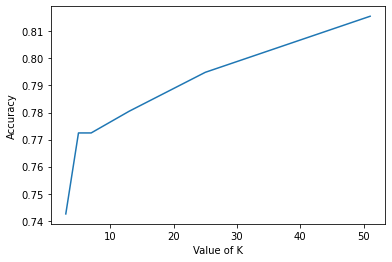

In [ ]:

hyper_k = [3,5,7,13,25,51]
accuracy = [0.7425149700598802, 0.7724550898203593, 0.7724550898203593, 0.7804878048780488, 0.7948717948717948, 0.8156028368794326]
plt.plot(hyper_k, accuracy)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")
plt.show()

# Plot for split (0.99, 0.01) 

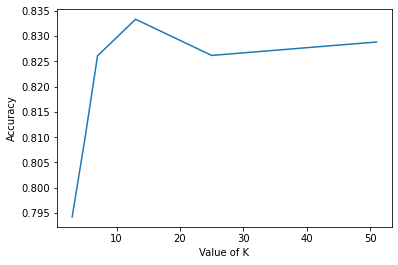

In [ ]:
hyper_k = [3,5,7,13,25,51]
accuracy = [0.79421768707483, 0.8096054888507719, 0.8260869565217391, 0.8333333333333334, 0.826171875, 0.8288288288288288]
plt.plot(hyper_k, accuracy)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")
plt.show()

# Plot for split (0.3, 1000 pts) for ngram range(2,3)

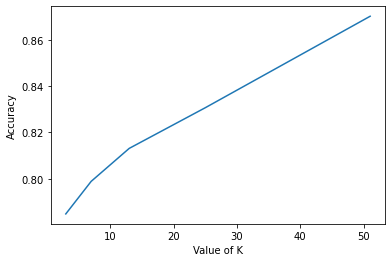

In [ ]:
hyper_k = [3,7,13,25,51]
accuracy = [0.7847769028871391, 0.7988505747126436, 0.8131147540983606, 0.8307086614173228, 0.8702702702702703]
plt.plot(hyper_k, accuracy)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")
plt.show()
"""
Accuracy
[0.7847769028871391, 0.7988505747126436, 0.8131147540983606, 0.8307086614173228, 0.8702702702702703]
Correct
[299, 278, 248, 211, 161]
Totals
[381, 348, 305, 254, 185]"""